In [1]:
import os

os.environ["EQX_ON_ERROR"] = "nan"
import sys
from functools import partial

import jax
import jax.numpy as jnp
import optax
from furax._instruments.sky import (
    FGBusterInstrument,
    get_noise_sigma_from_instrument,
    get_observation,
)
from furax.comp_sep import (
    negative_log_likelihood,
    spectral_cmb_variance,
)
from furax.obs.landscapes import FrequencyLandscape, HealpixLandscape
from furax.obs.operators import NoiseDiagonalOperator
from jax_grid_search import ProgressBar, optimize
from jax_healpy import get_clusters, get_cutout_from_mask
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

sys.path.append("../data")
from generate_maps import get_mask, simulate_D_from_params

In [2]:
mask = get_mask("GAL020")
nside = 64
npixel = 12 * nside**2
noise_ratio = 0.2
nb_noise_sim = 50

patch_counts = {
    "temp_dust_patches": 1,
    "beta_dust_patches": 100,
    "beta_pl_patches": 1,
}

max_count = {
    "temp_dust": 1,
    "beta_dust": 300,
    "beta_pl": 1,
}

max_patches = max(max_count.values())
(indices,) = jnp.where(mask == 1)

In [4]:
patch_indices = jax.tree.map(
    lambda c: get_clusters(mask, indices, c, jax.random.PRNGKey(0), max_centroids=max_patches),
    patch_counts,
)
masked_clusters = get_cutout_from_mask(patch_indices, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int32), masked_clusters)

nu = FGBusterInstrument.default_instrument().frequency
hp_landscape = HealpixLandscape(nside=nside, stokes="QU")
f_landscapes = FrequencyLandscape(nside, nu, "QU")

sky = {
    "cmb": hp_landscape.normal(jax.random.key(0)),
    "dust": hp_landscape.normal(jax.random.key(1)),
    "synchrotron": hp_landscape.normal(jax.random.key(2)),
}
masked_sky = get_cutout_from_mask(sky, indices)

In [5]:
best_params = {
    "temp_dust": jnp.full((patch_counts["temp_dust_patches"],), 20.0),
    "beta_dust": jnp.full((patch_counts["beta_dust_patches"],), 1.54),
    "beta_pl": jnp.full((patch_counts["beta_pl_patches"],), -3.0),
}

best_params_flat, tree_struct = jax.tree.flatten(best_params)
best_params = jax.tree.map_with_path(
    lambda path, x: x + jax.random.normal(jax.random.key(path[0].idx), x.shape) * 0.2,
    best_params_flat,
)
best_params = jax.tree.unflatten(tree_struct, best_params)

In [6]:
dust_nu0 = 150.0
synchrotron_nu0 = 20.0
masked_d = simulate_D_from_params(
    best_params,
    masked_clusters,
    nu,
    masked_sky,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
)

instrument = FGBusterInstrument.default_instrument()
pysm3_d = get_observation(instrument, 64, stokes_type="QU", tag="c1d0s0")

spectral_cmb_variance_fn = partial(
    spectral_cmb_variance, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)
negative_log_likelihood_fn = partial(
    negative_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

In [ ]:
white_noise = f_landscapes.normal(jax.random.key(420)) * noise_ratio
white_noise = get_cutout_from_mask(white_noise, indices, axis=1)
sigma = get_noise_sigma_from_instrument(instrument, nside, stokes_type="QU")
noise = white_noise * sigma
noised_d = masked_d + noise
N = NoiseDiagonalOperator((sigma* noise_ratio)**2, _in_structure=masked_d.structure)


best_nll = negative_log_likelihood_fn(
    best_params,
    nu=nu,
    d=noised_d,
    N=N,
    patch_indices=masked_clusters,
)
best_cmb_var = spectral_cmb_variance_fn(
    best_params,
    nu=nu,
    d=noised_d,
    N=N,
    patch_indices=masked_clusters,
)

In [8]:
base_params = {
    "beta_dust": 1.54,
    "temp_dust": 20.0,
    "beta_pl": -3.0,
}
lower_bound = {
    "beta_dust": 1.0,
    "temp_dust": 10.0,
    "beta_pl": -5.0,
}
upper_bound = {
    "beta_dust": 3.0,
    "temp_dust": 30.0,
    "beta_pl": 0.0,
}

In [ ]:
@partial(jax.jit, static_argnums=(5, 6))
def compute_minimum_variance(
    T_d_patches,
    B_d_patches,
    B_s_patches,
    planck_mask,
    indices,
    max_patches=25,
    progress_bar=None,
):
    def single_run(noise_id):
        key = jax.random.PRNGKey(noise_id)
        white_noise = f_landscapes.normal(key) * noise_ratio
        white_noise = get_cutout_from_mask(white_noise, indices, axis=1)
        instrument = FGBusterInstrument.default_instrument()
        sigma = get_noise_sigma_from_instrument(instrument, nside, stokes_type="QU")
        noise = white_noise * sigma
        noised_d = masked_d + noise

        N = NoiseDiagonalOperator((sigma* noise_ratio)**2, _in_structure=masked_d.structure)
        patch_indices = {
            "temp_dust_patches": T_d_patches,
            "beta_dust_patches": B_d_patches,
            "beta_pl_patches": B_s_patches,
        }
        patch_indices = jax.tree.map(
            lambda c: get_clusters(mask, indices, c, jax.random.key(0), max_centroids=max_patches),
            patch_indices,
        )
        guess_clusters = get_cutout_from_mask(patch_indices, indices)
        guess_clusters = jax.tree.map(lambda x: x.astype(jnp.int32), guess_clusters)

        guess_params = jax.tree.map(lambda v, c: jnp.full((c,), v), base_params, max_count)
        lower_bound_tree = jax.tree.map(lambda v, c: jnp.full((c,), v), lower_bound, max_count)
        upper_bound_tree = jax.tree.map(lambda v, c: jnp.full((c,), v), upper_bound, max_count)

        solver = optax.lbfgs()
        final_params, final_state = optimize(
            guess_params,
            negative_log_likelihood_fn,
            solver,
            max_iter=200,
            tol=1e-10,
            progress=progress_bar,
            progress_id=noise_id,
            lower_bound=lower_bound_tree,
            upper_bound=upper_bound_tree,
            nu=nu,
            N=N,
            d=noised_d,
            patch_indices=guess_clusters,
        )

        cmb_var = spectral_cmb_variance_fn(
            final_params, nu=nu, d=noised_d, N=N, patch_indices=guess_clusters
        )
        nll = negative_log_likelihood_fn(
            final_params, nu=nu, d=noised_d, N=N, patch_indices=guess_clusters
        )

        return {
            "value": cmb_var,
            "NLL": nll,
            "beta_dust": final_params["beta_dust"],
            "temp_dust": final_params["temp_dust"],
            "beta_pl": final_params["beta_pl"],
            "beta_dust_patches": guess_clusters["beta_dust_patches"],
            "temp_dust_patches": guess_clusters["temp_dust_patches"],
            "beta_pl_patches": guess_clusters["beta_pl_patches"],
        }

    return jax.vmap(single_run)(jnp.arange(nb_noise_sim))

In [34]:
progress_columns = [
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    TimeElapsedColumn(),
    TimeRemainingColumn(),
]

with ProgressBar(*progress_columns) as p:
    bad_res = compute_minimum_variance(
        1, 5, 1, mask, indices, max_patches=max_patches, progress_bar=p
    )

Output()

In [35]:
with ProgressBar(*progress_columns) as p:
    good_res = compute_minimum_variance(
        1, 100, 1, mask, indices, max_patches=max_patches, progress_bar=p
    )

Output()

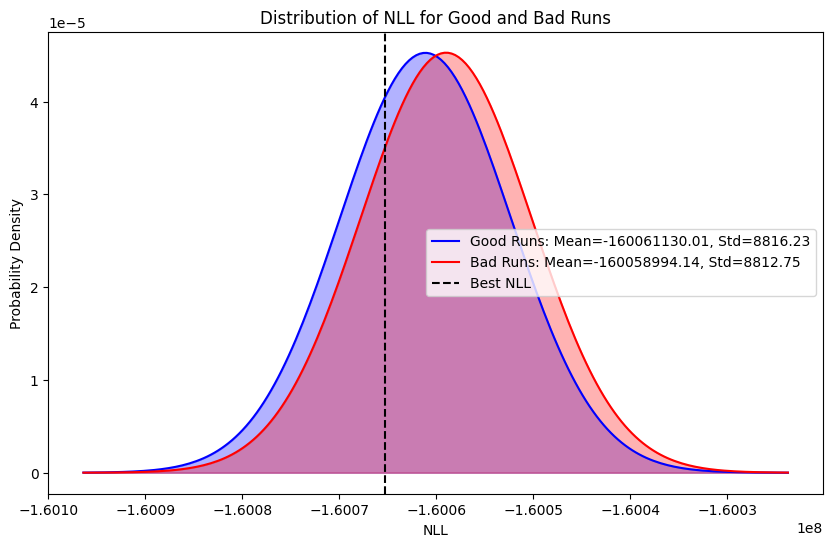

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Replace these with your actual NLL arrays from good_res and bad_res
good_NLL = np.array(good_res["NLL"])
bad_NLL = np.array(bad_res["NLL"])

# Calculate mean and standard deviation for each
mean_good = np.mean(good_NLL)
std_good = np.std(good_NLL)
mean_bad = np.mean(bad_NLL)
std_bad = np.std(bad_NLL)

# Define an x range covering both distributions (using 4 std devs on either side)
x_min = min(mean_good - 4 * std_good, mean_bad - 4 * std_bad)
x_max = max(mean_good + 4 * std_good, mean_bad + 4 * std_bad)
x = np.linspace(x_min, x_max, 200)

# Compute the probability density functions for each distribution
density_good = norm.pdf(x, mean_good, std_good)
density_bad = norm.pdf(x, mean_bad, std_bad)

# Plotting the bell curves
plt.figure(figsize=(10, 6))
plt.plot(
    x, density_good, color="blue", label=f"Good Runs: Mean={mean_good:.2f}, Std={std_good:.2f}"
)
plt.fill_between(x, density_good, color="blue", alpha=0.3)
plt.plot(x, density_bad, color="red", label=f"Bad Runs: Mean={mean_bad:.2f}, Std={std_bad:.2f}")
plt.fill_between(x, density_bad, color="red", alpha=0.3)
plt.axvline(best_nll, color="black", linestyle="--", label="Best NLL")

plt.xlabel("NLL")
plt.ylabel("Probability Density")
plt.title("Distribution of NLL for Good and Bad Runs")
plt.legend()
plt.show()